In [1]:
from lib.ekyn import *
from sage.utils import *
from sage.models import *
from lib.env import *
import datetime
import copy

In [2]:
hyperparameters = {
    'experiment_group_id':'encoder',
    'weight_decay':1e-2,
    'lr':3e-4,
    'batch_size':512,
    'robust':True,
    'norm':'layer',
    'dropout':.1,
    'stem_kernel_size':3,
    'widthi':[64],
    'depthi':[4],
    'n_output_neurons':3,
    'patience':100,
    'epochs':25,
    'device':f'cuda',
    'dataloaders':'leave_one_out',
    'dev_set':True,
    'fold':0
}

In [3]:
def get_epoched_dataloaders_loo(batch_size=512,shuffle_train=True,shuffle_test=False,robust=True,fold=0,dev_set=True,**kwargs):
    folds = get_leave_one_out_cv_ids_for_ekyn()
    train_ids,test_ids = folds[fold]
    if dev_set:
        dev_ids = [train_ids[-1]]
        del train_ids[-1]
        devloader = get_epoched_dataloader_for_ids(ids=dev_ids,batch_size=batch_size,shuffle=shuffle_train,robust=robust)

    trainloader = get_epoched_dataloader_for_ids(ids=train_ids,batch_size=batch_size,shuffle=shuffle_train,robust=robust)
    testloader = get_epoched_dataloader_for_ids(ids=test_ids,batch_size=batch_size,shuffle=shuffle_test,robust=robust)
    
    print('train_ids',train_ids)
    print('dev_ids',dev_ids)
    print('test_ids',test_ids)
    
    if dev_set:
        return {'trainloader':trainloader,'devloader':devloader,'testloader':testloader}
    return {'trainloader':trainloader,'testloader':testloader}
    
def get_dataloaders(dataloaders,robust,**kwargs):
    if robust:
        print("Getting Downsampled Data at 100 Hz!")
    if dataloaders=='leave_one_out':
        return get_epoched_dataloaders_loo(**kwargs)
    
dataloaders = get_dataloaders(**hyperparameters)
model = ResNetv2(block=ResBlockv2,**hyperparameters)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(params=model.parameters(),lr=hyperparameters['lr'],weight_decay=hyperparameters['weight_decay'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50)

Getting Downsampled Data at 100 Hz!
train_ids ['F1-1', 'C1-0', 'A1-1', 'E1-0', 'A4-0', 'B1-0', 'E4-0', 'F1-0', 'C4-1', 'D1-0', 'B3-1', 'A1-0', 'C4-0', 'F5-1']
dev_ids ['E4-1']
test_ids ['E2-1']
102915 params


In [4]:
state = {
    'start_time':datetime.datetime.now().strftime("%Y_%d_%m_%H_%M_%S"),
    'execution_time':0,
    'trainlossi':[],
    'devlossi':[],
    'testlossi':[],
    'best_dev_loss':torch.inf,
    'model':model,
    'scheduler':scheduler,
    'criterion':criterion,
    'optimizer':optimizer,
    'best_model_wts':copy.deepcopy(model.state_dict()),
}

In [5]:
for key in hyperparameters:
    state[key] = hyperparameters[key]

In [6]:
os.makedirs(f'{TMP_EXPERIMENTS_PATH}/{state["start_time"]}')

In [9]:
# TODO : allow for multiple dataloaders
# TODO : f1 score each epoch and add to plot_loss
# TODO : add best model epoch
# TODO : use a torch generator
for state in train(state,**dataloaders):
    state['model'].eval()
    with torch.no_grad():
        loss_total = 0
        for Xi,yi in dataloaders['testloader']:
            Xi,yi = Xi.to(state['device']),yi.to(state['device'])
            logits = state['model'](Xi)
            loss = state['criterion'](logits,yi)
            loss_total += loss.item()

        state['testlossi'].append(loss_total/len(dataloaders['testloader']))
    plot_loss(state,TMP_EXPERIMENTS_PATH)
    torch.save(state, f'{TMP_EXPERIMENTS_PATH}/{state["start_time"]}/state.pt')
torch.save(state, f'{TMP_EXPERIMENTS_PATH}/{state["start_time"]}/state.pt')

train: 0.2621, dev: 0.2842, best_dev: 0.2795:  12%|█▏        | 3/25 [00:44<05:29, 15.00s/it]

NameError: name 'devloader' is not defined

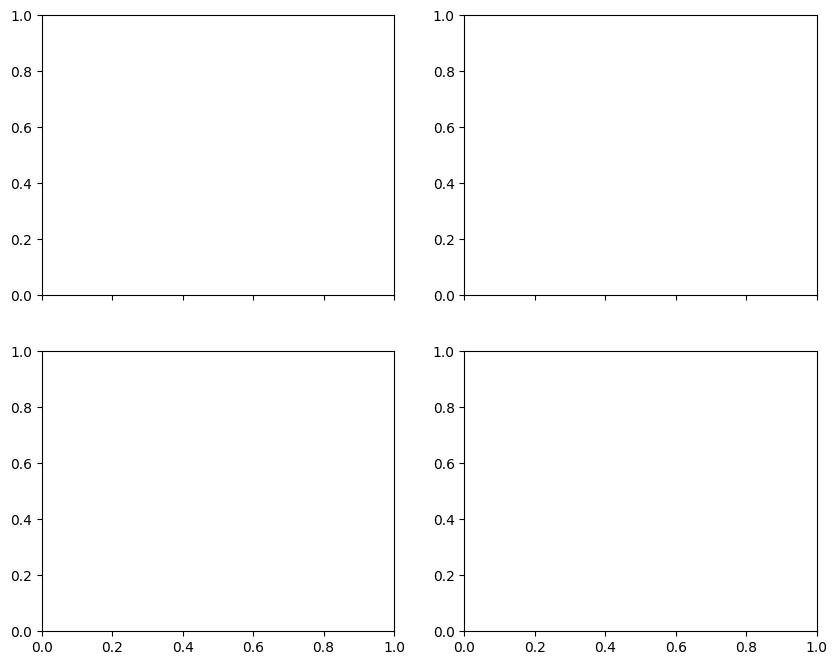

In [8]:
from sklearn.metrics import ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt

# Assuming evaluate, devloader, testloader, model, and state are defined

fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(10, 8))

# Loop through dataloaders and normalization types
for i, (dataloader, loader_name) in enumerate(zip([devloader, testloader], ['Dev', 'Test'])):
    for j, norm in enumerate(['true', 'pred']):
        # Evaluate the model
        loss, y_true, y_pred = evaluate(dataloader=dataloader, model=model, criterion=state['criterion'], device='cuda')

        # Plot the confusion matrix
        ConfusionMatrixDisplay.from_predictions(y_true, y_pred, normalize=norm, colorbar=False, ax=axes[i, j])
        
        # Set title and labels with more descriptive information
        f1 = f1_score(y_true, y_pred, average='macro')
        norm_type = 'Recall' if norm == 'true' else 'Precision'
        axes[i, j].set_title(f'{loader_name} - {norm_type} (F1: {f1:.3f})')

# Set the overall labels for the axes
axes[0, 0].set_xlabel('Predicted Label')
axes[0, 0].set_ylabel('True Label')
axes[1, 0].set_xlabel('Predicted Label')
axes[1, 0].set_ylabel('True Label')

# Adjust layout to avoid overlapping elements
plt.tight_layout()
plt.show()
